# Compare GPs + Plot

In [31]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot
import tueplots.figsizes

In [32]:
device = "cpu"
if device!="mps":
    torch.set_default_dtype(torch.float64)

In [33]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## True Function

In [34]:
d = 1
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768):
    # https://www.sfu.ca/~ssurjano/ackley.html
    assert x.ndim==2
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
fs = [lambda x: f_ackley(x,c=0), lambda x: f_ackley(x)]
num_tasks = len(fs)
ns = [
    torch.tensor([0,2**5],device=device),
    torch.tensor([2**5,2**4],device=device),
]

## Parameters

In [35]:
seqs_std = [
    qp.DigitalNetB2(d,seed=11,randomize="DS"),
    qp.DigitalNetB2(d,seed=13,randomize="DS"),
]
seqs_lattice = [
    qp.Lattice(d,seed=7),
    qp.Lattice(d,seed=2),
 ]
seqs_dnb2s = [
    qp.DigitalNetB2(d,seed=7,randomize="DS"),
    qp.DigitalNetB2(d,seed=2,randomize="DS"),
]
ngptypes = 3

In [36]:
xticks = torch.linspace(0,1,1001,device=device)[1:-1,None]
yticks = torch.vstack([fs[i](xticks) for i in range(num_tasks)])

## Independent Single Task GPs

In [37]:
pmeans = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
ci_lows = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
ci_highs = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
l2rerrors = torch.ones((ngptypes,num_tasks))
fgp_indep = [ 
    [
        fastgps.StandardGP(qp.KernelSquaredExponential(d=d,torchify=True,device=device),seqs=seqs_std[0]),
        fastgps.StandardGP(qp.KernelSquaredExponential(d=d,torchify=True,device=device),seqs=seqs_std[1]),
    ],
    [
        fastgps.FastGPLattice(qp.KernelShiftInvar(d=d,torchify=True,device=device),seqs=seqs_lattice[0]),
        fastgps.FastGPLattice(qp.KernelShiftInvar(d=d,torchify=True,device=device),seqs=seqs_lattice[1]),
    ],
    [
        fastgps.FastGPDigitalNetB2(qp.KernelDigShiftInvarCombined(d=d,torchify=True,device=device),seqs=seqs_dnb2s[0]),
        fastgps.FastGPDigitalNetB2(qp.KernelDigShiftInvarCombined(d=d,torchify=True,device=device),seqs=seqs_dnb2s[1]),
    ],
]
gpnames = [type(fgp_indep[i][0]).__name__ for i in range(ngptypes)]
for i in range(ngptypes):
    print(gpnames[i])
    for l in range(num_tasks):
        if ns[0][l]>0:
            x_next = fgp_indep[i][l].get_x_next(n=ns[0][l].item())
            y_next = torch.vstack([fs[i](x_next) for i in range(num_tasks)])
            fgp_indep[i][l].add_y_next(y_next[l])
            fgp_indep[i][l].fit()
            pmeans[i][l],_,_,ci_lows[i][l],ci_highs[i][l] = fgp_indep[i][l].post_ci(xticks)
            l2rerrors[i][l] = torch.linalg.norm(pmeans[i][l]-yticks[l])/torch.linalg.norm(yticks[l])

StandardGP
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.92e+06   | 1.92e+06  
            5.00e+00 | 8.84e+05   | 8.84e+05  
            1.00e+01 | 1.99e+04   | 1.99e+04  
            1.50e+01 | 7.67e+01   | 9.68e+01  
            2.00e+01 | 7.43e+01   | 7.43e+01  
            2.50e+01 | 7.29e+01   | 7.29e+01  
            3.00e+01 | 7.28e+01   | 7.29e+01  
            3.50e+01 | 7.28e+01   | 7.28e+01  
            4.00e+01 | 7.28e+01   | 7.28e+01  
            4.40e+01 | 7.28e+01   | 7.28e+01  
FastGPLattice
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.50e+03   | 1.50e+03  
            5.00e+00 | 3.38e+02   | 3.38e+02  
            1.00e+01 | 5.88e+01   | 5.97e+01  
            1.50e+01 | 5.73e+01   | 5.76e+01  
            2.00e+01 | 5.72e+01   | 5.73e+01  
            2.50e+01 | 5.72e+01   | 5.72e+01  
            2.80e+01 | 5.72e+01   |

## Multi-Task Fast GPs

In [38]:
fgp_multitask = [
    fastgps.StandardGP(qp.KernelMultiTask(qp.KernelSquaredExponential(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_std),
    fastgps.FastGPLattice(qp.KernelMultiTask(qp.KernelShiftInvar(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_lattice),
    fastgps.FastGPDigitalNetB2(qp.KernelMultiTask(qp.KernelDigShiftInvarCombined(d,torchify=True,device=device),num_tasks=num_tasks),seqs=seqs_dnb2s),
]
pmeans_mt = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
ci_lows_mt = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
ci_highs_mt = torch.nan*torch.ones((ngptypes,num_tasks,len(xticks)))
l2rerrors_mt = torch.ones((ngptypes,num_tasks))
for i in range(ngptypes):
    print(gpnames[i])
    x_next = fgp_multitask[i].get_x_next(n=ns[1])
    y_next = [fs[i](x_next[i]) for i in range(num_tasks)]
    fgp_multitask[i].add_y_next(y_next)
    fgp_multitask[i].fit()
    pmeans_mt[i],_,_,ci_lows_mt[i],ci_highs_mt[i] = fgp_multitask[i].post_ci(xticks)
    l2rerrors_mt[i] = torch.linalg.norm(pmeans_mt[i]-yticks,dim=-1)/torch.linalg.norm(yticks,dim=-1)

StandardGP
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 3.66e+06   | 3.66e+06  
            5.00e+00 | 1.15e+06   | 1.15e+06  
            1.00e+01 | 2.52e+04   | 2.52e+04  
            1.50e+01 | 1.33e+02   | 2.21e+02  
            2.00e+01 | 1.09e+02   | 1.09e+02  
            2.50e+01 | 1.02e+02   | 1.02e+02  
            3.00e+01 | 9.42e+01   | 9.42e+01  
            3.50e+01 | 9.18e+01   | 9.20e+01  
            4.00e+01 | 9.17e+01   | 9.18e+01  
            4.50e+01 | 9.17e+01   | 9.17e+01  
            4.80e+01 | 9.17e+01   | 9.17e+01  
FastGPLattice
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 6.63e+02   | 6.63e+02  
            5.00e+00 | 9.82e+01   | 9.82e+01  
            1.00e+01 | 8.17e+01   | 8.17e+01  
            1.50e+01 | 7.36e+01   | 7.36e+01  
            2.00e+01 | 7.31e+01   | 7.31e+01  
            2.50e+01 | 7.31e+01   |

## Compare Accuracy

In [39]:
pd.DataFrame({gpnames[i]+" task %d"%j: [l2rerrors[i,j].item(),l2rerrors_mt[i,j].item()] for j in range(num_tasks) for i in range(ngptypes)},["single task GP","MTGP"])

,StandardGP task 0,FastGPLattice task 0,FastGPDigitalNetB2 task 0,StandardGP task 1,FastGPLattice task 1,FastGPDigitalNetB2 task 1
single task GP,1.00000,1.000000,1.000000,0.062289,0.064188,0.075656
MTGP,0.01473,0.014621,0.043651,0.061912,0.065321,0.054531


## Plot

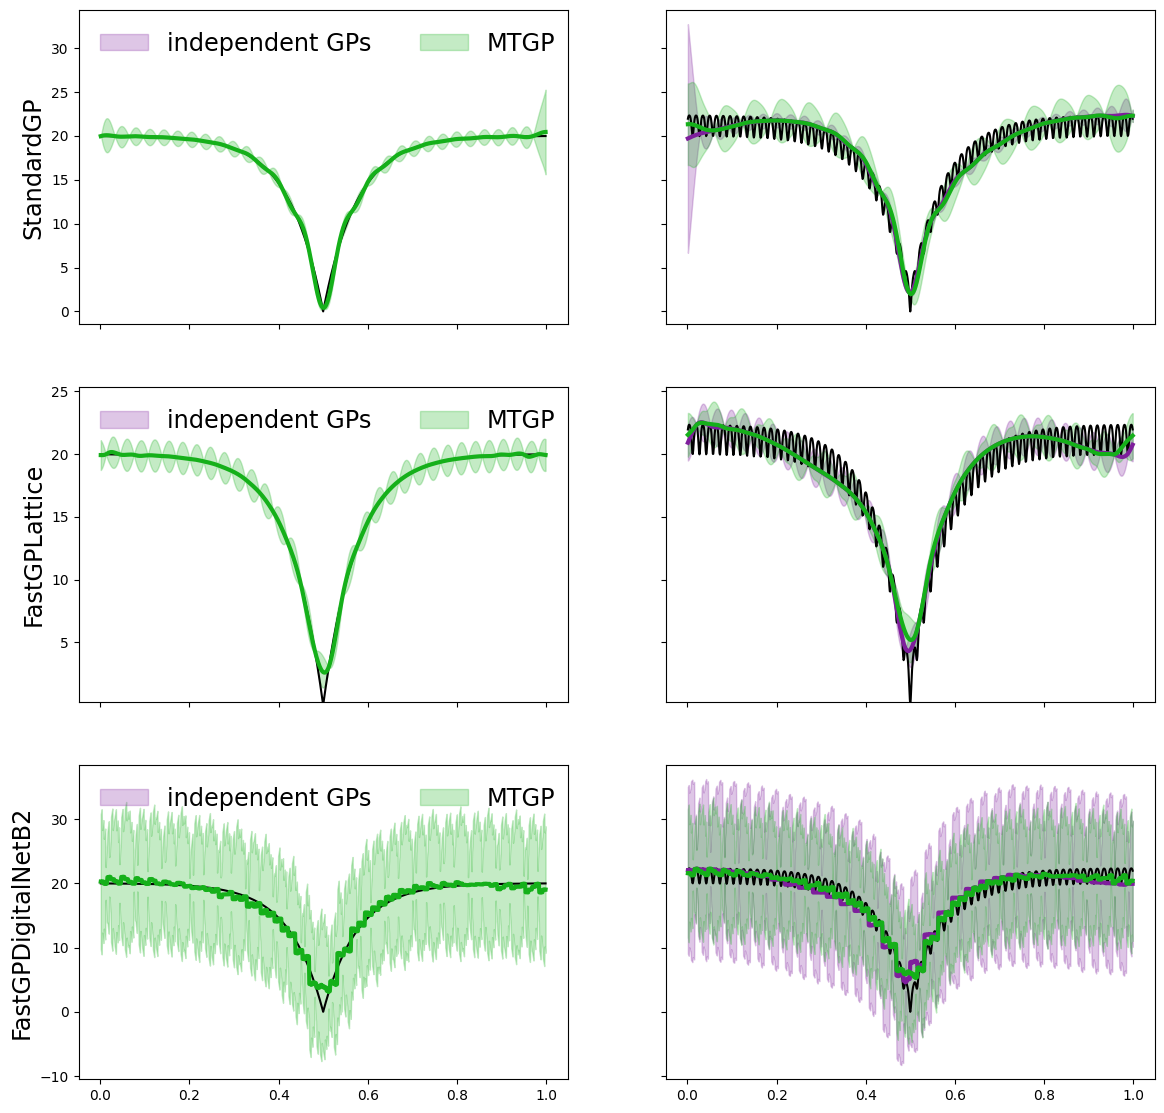

In [40]:
fig,ax = pyplot.subplots(nrows=ngptypes,ncols=num_tasks,figsize=(WIDTH,WIDTH/num_tasks*ngptypes/1.5),sharex=True,sharey="row")
ax = ax.reshape((ngptypes,num_tasks))
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),yticks[l].cpu(),color="k",linewidth=LINEWIDTH/2)
    pltmin = np.nanmin([ci_lows[i][l].min() for l in range(num_tasks)]+[ci_lows_mt[i].min()])
    pltmax = np.nanmax([ci_highs[i][l].max() for l in range(num_tasks)]+[ci_highs_mt[i].max()])
    ax[i,0].set_ylim([pltmin-.05*(pltmax-pltmin),pltmax+.05*(pltmax-pltmin)])
    ax[i,0].set_ylabel(gpnames[i],fontsize="xx-large")
fig.savefig("./mtgps0.1d.pdf",bbox_inches="tight")
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),pmeans[i][l].cpu(),color=colors[0],linewidth=LINEWIDTH)
        ax[i,l].fill_between(xticks[:,0].cpu(),ci_lows[i][l].cpu(),ci_highs[i][l].cpu(),color=colors[0],alpha=_alpha,label="independent GPs")
    ax[i,0].legend(frameon=False,loc="upper left",ncols=2,fontsize="xx-large") 
fig.savefig("./mtgps1.1d.pdf",bbox_inches="tight")
for i in range(ngptypes):
    for l in range(num_tasks):
        ax[i,l].plot(xticks[:,0].cpu(),pmeans_mt[i][l].cpu(),color=colors[1],linewidth=LINEWIDTH)
        ax[i,l].fill_between(xticks[:,0].cpu(),ci_lows_mt[i][l].cpu(),ci_highs_mt[i][l].cpu(),color=colors[1],alpha=_alpha,label="MTGP")
    ax[i,0].legend(frameon=False,loc="upper left",ncols=2,fontsize="xx-large") 
fig.savefig("./mtgps2.1d.pdf",bbox_inches="tight")